In [2]:
import pandas as pd
import numpy as np

import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    accuracy_score, 
    f1_score, 
    confusion_matrix, 
    RocCurveDisplay
)
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [3]:
file_path= r"C:\Users\ashfa\Desktop\work_py\Data Projects\heart_2020_cleaned.csv"
df = pd.read_csv(file_path)

In [4]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [6]:
df.shape

(319795, 18)

In [7]:
missing_values= df.isnull().sum()
print(missing_values)

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64


In [9]:
duplicated_values = df.duplicated()
print(duplicated_values)

0         False
1         False
2         False
3         False
4         False
          ...  
319790    False
319791    False
319792    False
319793    False
319794    False
Length: 319795, dtype: bool


In [10]:
def split_df(df, y_col, random_state, test_size):
    x_cols = [c for c in df.columns if c != y_col]
    
    # Now to split dataset for training and testing purpose
    X_train, X_test, y_train, y_test = train_test_split(
        df[x_cols],
        df[[y_col]],
        stratify=df[[y_col]],
        random_state=random_state,
        test_size=test_size
    )
    
    # Now to add data for training and testing
    X_train[y_col] = y_train
    X_test[y_col] = y_test
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

Y_COL= "HeartDisease"
train_df, test_df = split_df(df, Y_COL, random_state=0, test_size=0.3)
base_ratio = len(train_df[train_df[Y_COL] == 'Yes']) / len(train_df)

unique_values = ', '.join(train_df[Y_COL].unique())
print(Y_COL + " value: " + unique_values)
print(Y_COL + " =Yes \t ratio: " + str(round(base_ratio, 4)))

HeartDisease value: No, Yes
HeartDisease =Yes 	 ratio: 0.0856


In [11]:
t_df = df.copy()

# Binary columns whose values are changed into binary values
binary_cols = [
    'HeartDisease', 'Sex', 'Smoking', 'AlcoholDrinking', 
    'Stroke', 'Asthma', 'DiffWalking', 'PhysicalActivity', 'KidneyDisease', 'SkinCancer'
]
# Replace unique values with 0s and 1s
for col in binary_cols:
    t_df[col] = t_df[col].replace(list(t_df[col].unique()), [0, 1])

# Using OneHotEncoder for Categorical column Race
race_encoder = ce.OneHotEncoder(cols='Race', handle_unknown='return_nan', return_df=True)

# Using OneHotEncoder for Diabetic column
t_df['Diabetic'] = t_df['Diabetic'].replace({
    'Yes': 1,
    'Yes (during pregnancy)': 1,
    'No': 0,
    'No, borderline diabetes': 0
})

diabetic_encoder = ce.OneHotEncoder(cols='Diabetic', handle_unknown='return_nan', return_df=True)

# Using OrdinalEncoder for ordered Category column
age_encoder = ce.OrdinalEncoder(cols=['AgeCategory'], return_df=True, mapping=[{
        'col': 'AgeCategory',
        'mapping': {'18-24': 0, '25-29': 1, '30-34': 2, '35-39': 3, 
            '40-44': 4, '45-49': 5, '50-54': 6, '55-59': 7, 
            '60-64': 8, '65-69': 9, '70-74': 10, '75-79': 11, 
            '80 or older': 12
        }}]
)

# OrdinalEncoder for 'GenHealth' column
health_encoder = ce.OrdinalEncoder(cols=['GenHealth'], return_df=True, mapping=[{
        'col': 'GenHealth',
        'mapping': {
            'Poor': 0, 'Fair': 1, 'Good': 2, 'Very good': 3, 'Excellent': 4
        }}]
)

# Integrtting the encoders to the Dataframe
t_df = age_encoder.fit_transform(t_df)
t_df = health_encoder.fit_transform(t_df)
t_df = race_encoder.fit_transform(t_df)
t_df = diabetic_encoder.fit_transform(t_df)

In [13]:
t_df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,Race_5,Race_6,Diabetic_1,Diabetic_2,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,0,0,0,3.0,30.0,0,0,7,...,0.0,0.0,1.0,0.0,0,3,5.0,0,0,0
1,0,20.34,1,0,1,0.0,0.0,0,0,12,...,0.0,0.0,0.0,1.0,0,3,7.0,1,0,1
2,0,26.58,0,0,0,20.0,30.0,0,1,9,...,0.0,0.0,1.0,0.0,0,1,8.0,0,0,1
3,0,24.21,1,0,0,0.0,0.0,0,0,11,...,0.0,0.0,0.0,1.0,1,2,6.0,1,0,0
4,0,23.71,1,0,0,28.0,0.0,1,0,4,...,0.0,0.0,0.0,1.0,0,3,8.0,1,0,1


In [14]:
scaler=MinMaxScaler()
names=t_df.columns
d=scaler.fit_transform(t_df)
scaled_df=pd.DataFrame(d,columns=names)

In [15]:
t_df.head()  #all columns has been changed into binary values to perform analysis

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,Race_5,Race_6,Diabetic_1,Diabetic_2,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,0,0,0,3.0,30.0,0,0,7,...,0.0,0.0,1.0,0.0,0,3,5.0,0,0,0
1,0,20.34,1,0,1,0.0,0.0,0,0,12,...,0.0,0.0,0.0,1.0,0,3,7.0,1,0,1
2,0,26.58,0,0,0,20.0,30.0,0,1,9,...,0.0,0.0,1.0,0.0,0,1,8.0,0,0,1
3,0,24.21,1,0,0,0.0,0.0,0,0,11,...,0.0,0.0,0.0,1.0,1,2,6.0,1,0,0
4,0,23.71,1,0,0,28.0,0.0,1,0,4,...,0.0,0.0,0.0,1.0,0,3,8.0,1,0,1


In [16]:

class_0 = scaled_df[scaled_df['HeartDisease'] == 0]
class_1 = scaled_df[scaled_df['HeartDisease'] == 1]

class_1_sampled = class_1.sample(len(class_0), replace=True)

# creating the training DataFrame
train_df = pd.concat([class_0, class_1_sampled], axis=0)
print('Data in Train:')
print(train_df['HeartDisease'].value_counts())


Data in Train:
HeartDisease
0.0    292422
1.0    292422
Name: count, dtype: int64


In [17]:
# columns to train model
x = train_df[[
    'AgeCategory',  
    'DiffWalking',  
    'Stroke', 
    'Diabetic_1',
    'Diabetic_2',  
    'KidneyDisease',
    'SkinCancer'
]]

# column to  predict
y = train_df['HeartDisease']  

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42 )

print(f"Training data size: {x_train.shape[0]} records")
print(f"Testing data size: {x_test.shape[0]} records")


Training data size: 467875 records
Testing data size: 116969 records


In [18]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train, y_train)

clf_y_predict = clf.predict(x_test)

print(f'Model: {str(clf)}')
print(f'Accuracy score: {accuracy_score(y_test, clf_y_predict)}')
print(f'Precision score: {precision_score(y_test, clf_y_predict)}')
print(f'Recall score: {recall_score(y_test, clf_y_predict)}')
print(f'F1-score: {f1_score(y_test, clf_y_predict)}')


Model: RandomForestClassifier()
Accuracy score: 0.7319375219075139
Precision score: 0.7098018559543913
Recall score: 0.7840006844626968
F1-score: 0.745058501166771


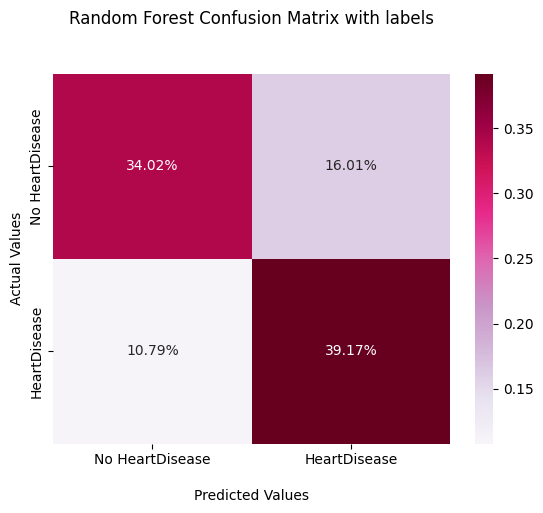

In [19]:
# Visualizing using Confusion Matrix for Random Forest Classifier
cm = confusion_matrix(y_test, clf_y_predict)
ax = sns.heatmap(cm / np.sum(cm), annot=True, cmap='PuRd', fmt='.2%')

ax.set_title('Random Forest Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

# x& y tick labels
ax.xaxis.set_ticklabels(['No HeartDisease', 'HeartDisease'])
ax.yaxis.set_ticklabels(['No HeartDisease', 'HeartDisease'])
plt.show()


In [20]:
#Logistic Regression Model w/ random state 0 for reproducability
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

lr_y_predict = lr.predict(x_test)

print(f'Model: {str(lr)}')
print(f'Accuracy score: {accuracy_score(y_test, lr_y_predict):.4f}')
print(f'Precision score: {precision_score(y_test, lr_y_predict):.4f}')
print(f'Recall score: {recall_score(y_test, lr_y_predict):.4f}')
print(f'F1-score: {f1_score(y_test, lr_y_predict):.4f}')


Model: LogisticRegression(random_state=0)
Accuracy score: 0.7294
Precision score: 0.7152
Recall score: 0.7617
F1-score: 0.7377


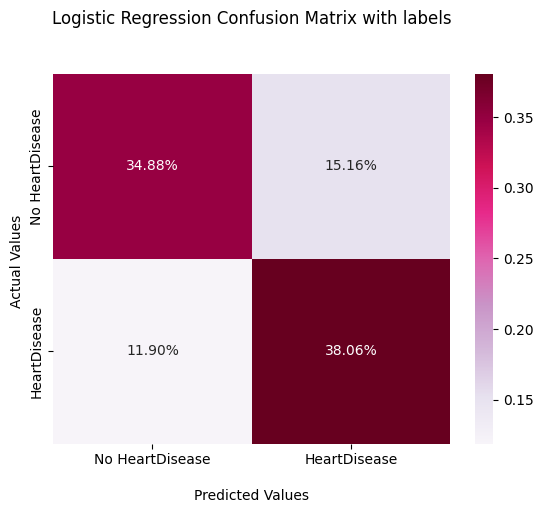

In [21]:
# Confusion Matrix for Logistic Regression 
cm = confusion_matrix(y_test, lr_y_predict)
ax = sns.heatmap(cm / np.sum(cm), annot=True, cmap='PuRd', fmt='.2%')

ax.set_title('Logistic Regression Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

# X & Y tick labels
ax.xaxis.set_ticklabels(['No HeartDisease', 'HeartDisease'])
ax.yaxis.set_ticklabels(['No HeartDisease', 'HeartDisease'])
plt.show()


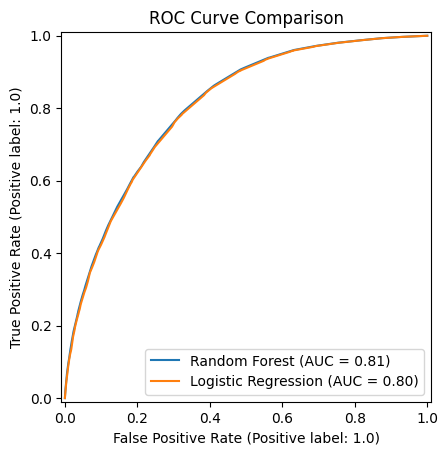

In [22]:

fig, ax = plt.subplots()

# ROC curve for Random Forest Classifier
rdf_disp = RocCurveDisplay.from_estimator(clf, x_test, y_test, ax=ax, name='Random Forest')

# ROC curve for Logistic Regression
lg_disp = RocCurveDisplay.from_estimator(lr, x_test, y_test, ax=ax, name='Logistic Regression')


plt.title('ROC Curve Comparison')
plt.show()


Both the Random Forest Classifier and the Logistic Regression's ROC curve yields an AUC of 0.8;  Demonstrating its effectiveness in assessing heart disease likelihood. While not perfect, it provides a reliable and
interpretable performance.